In [58]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import scipy
import matplotlib.colors as mcolors
from scipy.stats import bootstrap
import random as rd
from file_helper import load_all_files, create_prefix_from_list
from distutils.spawn import find_executable
from itertools import cycle
import os
from sklearn.linear_model import LinearRegression

import pickle as pk
from statistic.generate_statistics import genSstat, get_ranking_results, reject_if_bad_test
from plotting import plot_stat, put_plot_rank, get_color
from test_distribution import float_to_print
from table_helper import build_latex_table

In [59]:
path_dir = 'results'

# experiment  = 'SYNTH'     
# power_base = 10
# U = power_base**power_base
# m_per_splits = 10000
# init_e = 0.05
# init_b = 0.3
# splits = 10
# S = 4
# ratio = 5
# distribution_type = 'STAIRS'  # STAIRS
# TYPE = 'FLAT'
# prefix = create_prefix_from_list(
#        {'exp': experiment+TYPE, 'U': U, 'm_per_splits': m_per_splits, 'splits': splits, 'S': S, 'ratio': ratio, 'b': init_b, 'e': init_e})      

experiment  = 'GEN'
power_base = 6
U = power_base**power_base
m_per_splits = 10000
S = 2
TYPE = 'SHARP'
ratio = 3
splits = 10
prefix = create_prefix_from_list(
        {'exp': experiment+TYPE, 'U': U, 'm_per_splits': m_per_splits, 'splits': splits, 'S': S, 'ratio': ratio})      

experiment = "GEN"

list_files = load_all_files(path_dir)
file_to_load = prefix

for file in list_files:
    file_name = file.split('.pk')[0]
    
    if file_to_load in file_name:
        print('found', file_to_load)
        with open(os.path.join(path_dir, file), 'rb') as f:  # load the data
                data = pk.load(f)
                data = data['data']

found exp:GENSHARP_U:46656_m_per_splits:10000_splits:10_S:2_ratio:3


In [60]:
data.keys()

dict_keys(['S', 'test', 'binning', 'A', 'nll', 'e', 'std_nll', 'l1'])

In [61]:
list_of_title_q = list(data['A'].keys())
def format_name(q_name):
    if experiment == 'SYNTH':
        epsilon = q_name.split(' ')[1]
        if float(epsilon) ==0:
            return '$p$'
        string = '$q_{{{:.2f}}}$'.format(float(epsilon))
        return string
    else:
        return q_name


0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148
0.009297234099330148


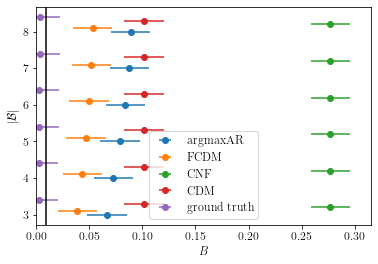

In [62]:
maxvalue = 0
for q_index, q_name in enumerate(list_of_title_q):
    
    emp_l1_for_all_B = data['A'][q_name]
    first = True
    for B, A_trials in emp_l1_for_all_B.items():
       
        x = [np.mean(A_trials)]
        y = [B+q_index*0.1]         
        errors = np.mean(data['e'][q_name][B])
        print(errors)
        if first:
            first = False
            plt.errorbar(x, y, xerr=errors*2, fmt = 'o', color=get_color(q_index), label=format_name(q_name))
        else:
            plt.errorbar(x, y, xerr=errors*2, fmt = 'o', color=get_color(q_index))
        maxvalue = max(maxvalue, (x+errors)*1.1)
plt.axvline(x=errors, color='k')
plt.xlim((0,maxvalue))
plt.ylabel('$|\mathcal{B}|$')
plt.xlabel('$B$')
plt.legend()
plt.show()
plt.savefig(file_to_load+'B.pdf')

plt.close()
# print(q_index)
# print(len(list_of_title_q))
# y_positions = [i for i in range(q_index+1)]
# plt.yticks(y_positions, ['']+list_of_title_q+['']) 

# # plt.savefig(file_to_load+'A.pdf')
# plt.show()

In [63]:

rows = []
index_next_q = 0
for q_name in list_of_title_q:
    values = []
    index_next_q +=1
   
    if experiment == 'SYNTH':
        
        string_nll = float_to_print(np.mean(data['nll'][q_name])) 
        
        if len(list_of_title_q)>index_next_q:
                print(q_name, 'vs', list_of_title_q[index_next_q])
                nll_next = data['nll'][list_of_title_q[index_next_q]]
                nll = data['nll'][q_name]
                test = scipy.stats.wilcoxon(nll, nll_next)
                if test[1]<0.05 :
                    string_nll = string_nll+"*"

        values.append(string_nll)
    float_val = []
    for key, val in data['A'][q_name].items():
        mean_val = np.mean(val)
        float_val.append(mean_val)
        string_val = float_to_print(mean_val*100, num_d=2)
        
        if len(list_of_title_q)>index_next_q:
          
            val_next = data['A'][list_of_title_q[index_next_q]][key]
            
            test = scipy.stats.wilcoxon(val, val_next)
            if test[1]<0.05 :
                string_val = string_val+"*"
        values.append(string_val)
    x = np.array(list(range(len(float_val))))
    x = x.reshape(-1,1)
    
    reg = LinearRegression().fit(x, float_val)
    values.append(reg.coef_*100)
        
    rows.append([format_name(q_name)] + values)
top = [''] 
if experiment == 'SYNTH':
    top.append('nll')
for B in data['A'][q_name].keys():
    top = top + ['$B_'+str(B)+'$']
    #top = top + [ '$tv$']
top.append('slope')
print(rows)
build_latex_table([top]+rows, caption=TYPE + '$\Omega$=' +str(U)+ " m="+ str( m_per_splits*splits)+ ' S:'+str(S), label=prefix)

[['argmaxAR', '6.66*', '7.28*', '7.90*', '8.40*', '8.78*', '8.90*', array([0.46348629])], ['FCDM', '3.89*', '4.36*', '4.70*', '4.98*', '5.20*', '5.32*', array([0.28351238])], ['CNF', '27.70*', '27.70*', '27.70*', '27.70*', '27.70*', '27.70*', array([-1.58603289e-16])], ['CDM', '10.14*', '10.14*', '10.14*', '10.14*', '10.14*', '10.16*', array([0.00252419])], ['ground truth', '0.24', '0.24', '0.28', '0.32', '0.36', '0.40', array([0.03442819])]]
               $B_3$    $B_4$    $B_5$    $B_6$    $B_7$    $B_8$    slope 
argmaxAR       6.66*    7.28*    7.90*    8.40*    8.78*    8.90*    0.463 
FCDM           3.89*    4.36*    4.70*    4.98*    5.20*    5.32*    0.284 
CNF            27.70*   27.70*   27.70*   27.70*   27.70*   27.70*   -0.000
CDM            10.14*   10.14*   10.14*   10.14*   10.14*   10.16*   0.003 
ground truth   0.240    0.240    0.280    0.320    0.360    0.400    0.034 

Latextable Output:
\begin{table}
	\begin{center}
		\begin{tabular}{lccccccc}
			 & $B_3$ & $B_4$